In [2]:
from IPython.lib import passwd
password = passwd("")
password

'sha1:a187b420cce1:944fa0dd897778efdd8843d16d017cf531da3cad'

In [1]:
%matplotlib inline
# jt -t oceans16 -f fira -fs 10 -cellw 1200 -T -N -cursc r
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path
import h5py
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')
import pandas as pd
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

from tensorflow.keras.layers.experimental import preprocessing

from hera_sim import foregrounds, noise, sigchain, rfi, simulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2.4.0


/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

# Experimentation
### RFI Mask
This is a boolean mask: `True` = RFI, `False` = no RFI

Parameters:
- 6 hours in JD, 1500 units
  - times match: using range π/2 for lsts in vis plot, with 1500 snapshots
- 1024 channels, 100-200 MHz

In [2]:
f = h5py.File("mask_HERA.hdf5", "r")
plt.figure(figsize=(20,12))
saurabhs_mask = f['mask']
# plt.imshow((mask[()]), cmap='inferno_r', aspect='auto',
#            origin='lower', vmin=0, vmax=1,
#            extent=(f['axes']['frequency'][0]/1e6,f['axes']['frequency'][-1]/1e6,
#                   f['axes']['time'][0], f['axes']['time'][-1]))
# plt.xlabel('Frequency (MHz)')
# plt.ylabel('Time (JD)')
# plt.grid()
# plt.colorbar()
# plt.show()
print(saurabhs_mask.shape)
# print(mask[()])

num_jd = saurabhs_mask.shape[0]
num_freq_channels = saurabhs_mask.shape[1]

(1500, 1024)


<Figure size 1440x864 with 0 Axes>

### Generate custom masks

Take horizontal or vertical pixel slice of the mask. Spans of the `True` sections = spans of RFI

In [3]:
'''
Get RFI spans from one row/col
'''
def get_RFI_spans(row, isRow=False):
    spans = [(key, sum(1 for _ in group)) for key, group in itertools.groupby(row)]
#     spans = spans[1:-1] # remove first and last element of mask?
    if len(spans) == 1:
        raise Exception("Error: all values in the row/col are True; select another one")
    if isRow:
        start = spans[0][1]
        end = spans[-1][1]
        print("RFI bookends", start, end)
        spans = spans[1:-1]
        return spans, start, end
    else:
        return spans

rfi_widths, start_mask, end_mask = get_RFI_spans(saurabhs_mask[1434], isRow=True)
rfi_heights = get_RFI_spans(saurabhs_mask[:,166])

print("RFI widths", rfi_widths)
# print("RFI heights", rfi_heights)

RFI bookends 95 111
RFI widths [(False, 20), (True, 2), (False, 15), (True, 1), (False, 2), (True, 1), (False, 1), (True, 4), (False, 10), (True, 1), (False, 12), (True, 1), (False, 3), (True, 1), (False, 6), (True, 1), (False, 6), (True, 1), (False, 126), (True, 1), (False, 1), (True, 5), (False, 9), (True, 1), (False, 14), (True, 1), (False, 12), (True, 38), (False, 76), (True, 5), (False, 9), (True, 2), (False, 27), (True, 2), (False, 187), (True, 6), (False, 12), (True, 1), (False, 50), (True, 4), (False, 43), (True, 1), (False, 14), (True, 2), (False, 1), (True, 6), (False, 9), (True, 7), (False, 2), (True, 11), (False, 15), (True, 4), (False, 8), (True, 4), (False, 1), (True, 12), (False, 1)]


Generate randomized mask from spans

In [4]:
def plot_mask(mask, mask2, mask3):
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.grid(False)
    plt.imshow(mask, cmap='inferno_r') # black is RFI
    plt.subplot(1, 3, 2)
    plt.grid(False)
    plt.imshow(mask2, cmap='inferno_r')
    plt.subplot(1, 3, 3)
    plt.grid(False)
    plt.imshow(mask3, cmap='inferno_r')

'''
Generate random RFI mask with dimensions time x freq, given RFI spans from a real mask
'''
def generate_one_mask(time, freq, widths, heights, plot=False):
    random.shuffle(widths)
    random.shuffle(heights)
    
    # row by row
    one_row = []
    for w in widths:
        one_row.extend([w[0]] * w[1])
    mask = np.tile(one_row, (time, 1)) # copy one_row `time` times in the vertical direction
#     print(mask.shape)
#     print(widths)
    
    # col by col
    one_col = []
    for w in heights:
        one_col.extend([w[0]] * w[1])
    mask2 = np.tile(np.array(one_col).reshape((time, 1)), (1, freq))
#     print(mask2.shape)
    
    combined_mask = np.logical_or(mask, mask2) # any cell with True will have RFI
    if plot:
        plot_mask(mask, mask2, combined_mask)
    return combined_mask

'''
Generate n masks
'''
def generate_masks(n, time, freq, widths, heights):
    res = []
    for i in range(n):
        res.append(generate_one_mask(time, freq, widths, heights))
    return np.array(res)


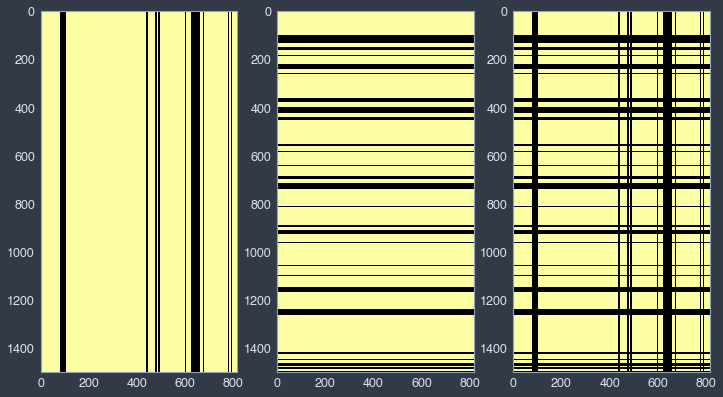

In [5]:
custom_mask = generate_one_mask(num_jd, num_freq_channels-(start_mask+end_mask), rfi_widths, rfi_heights, plot=True)
# print(custom_mask)

### Visibility waterfall plot

In [6]:
# sigchain.gen_gains?

In [7]:
'''
Generate one visibility waterfall plot
Returns a 2D (x,y) plot, as well as a channel-separated plot (x,y,2)
'''
def generate_one_vis(lsts, fqs, bl_len_ns):
    # point-source and diffuse foregrounds
    Tsky_mdl = noise.HERA_Tsky_mdl['xx']
    vis = foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl)
    vis += foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

    # noise
    tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
    t_rx = 150.
#     OMEGA_P = (0.72)*np.ones(1024) # from before; fraction of sky telescope is looking at; normalizes noise
    OMEGA_P = noise.bm_poly_to_omega_p(fqs) # default; from the hera_sim docs
    nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
    vis += nos_jy
    
    # crosstalk, gains
    xtalk = sigchain.gen_whitenoise_xtalk(fqs)
#     g = sigchain.gen_gains(fqs, [1,2,3,4], 0) # default 0.1 # leave out for now
    vis = sigchain.apply_xtalk(vis, xtalk)
#     vis = sigchain.apply_gains(vis, g, (1,2))

    # separate new_vis into real and imaginary channels
    real = vis.real
    imag = vis.imag
    new_vis = np.zeros((vis.shape[0], vis.shape[1], 2))
    new_vis[:, :, 0] = real
    new_vis[:, :, 1] = imag
#     print(vis.shape)
#     print(new_vis.shape)
#     print(vis[5][66])
#     print(new_vis[5][66])

    return vis, new_vis

'''
Plot one visibility waterfall plot
MX is max value of color scale in the plot
DRNG = MX - min value of color scale in the plot
'''
def plot_one_vis(input_vis, ylim, MX, DRNG, figsize, title=None):
    # consolidate real and imag channels of vis if necessary
    print(input_vis.shape)
    if input_vis.ndim > 2: 
        vis = np.zeros((input_vis.shape[0], input_vis.shape[1]), dtype = 'complex128')
        vis[:, :] = input_vis[:, :, 0] + input_vis[:, :, 1]*1j
    else:
        vis = input_vis

    # plot
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    fig.sca(ax1)
    uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG)
    if title:
        plt.suptitle(title)
    plt.grid(False)  
    plt.colorbar(label=r"Amplitude [log$_{10}$(V/Jy)]")
    plt.ylim(0,ylim)

    fig.sca(ax2)
    uvtools.plot.waterfall(vis, mode='phs')
    plt.grid(False)
    plt.colorbar(label="Phase [rad]")
    plt.ylim(0,ylim)
    plt.xlabel("Frequency channel")

    fig.text(0.02, 0.5, 'LST [rad]', ha='center', va='center', rotation='vertical')

'''
Generate n visibility waterfall plots
'''
def generate_vis(n, lsts, fqs, bl_len_ns):
    return np.array([generate_one_vis(lsts, fqs, bl_len_ns)[1] for i in range(n)]) # get separated vis

Calculate start freq, end freq, and # channels

In [8]:
# Original range: 100 - 200 GHz, 1024 channels
start_freq = (100 + 100*start_mask/num_freq_channels) / 1000

end_freq = (200 - 100*end_mask/num_freq_channels) / 1000
num_reduced_channels = num_freq_channels - start_mask - end_mask
print(start_freq, end_freq, num_reduced_channels)

0.10927734375 0.18916015625 818


(-61.067893911077256+30.033461191624717j) -61.067893911077256 30.033461191624717
<class 'numpy.complex128'> <class 'numpy.complex128'>
(1500, 818)
(1500, 818, 2)


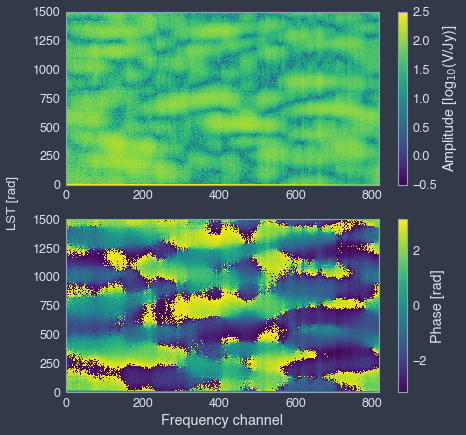

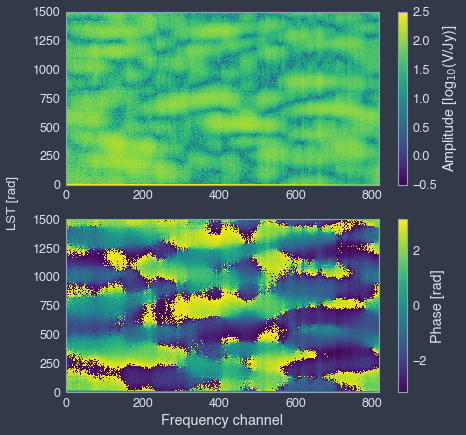

In [9]:
lsts = np.linspace(0, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
# 1500 to match the mask; π/2 ~ 6h
fqs = np.linspace(start_freq, end_freq, num_reduced_channels, endpoint=False) # frequencies in GHz; start freq, end freq, number of channels
# fqs = np.linspace(.1, .2, 1024, endpoint=False) # original
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

vis, vis_separated = generate_one_vis(lsts, fqs, bl_len_ns)

print(vis[15][149], vis_separated[15][149][0], vis_separated[15][149][1])
print(type(vis[15][149]), type(vis_separated[15][149][0] + 1j*vis_separated[15][149][1]))

plot_one_vis(vis, 1500, 2.5, 3, (7,7))
plot_one_vis(vis_separated, 1500, 2.5, 3, (7,7))

# plt.imshow(np.log(np.abs(vis[:,:,0])))

In [10]:
# res = np.zeros((vis_separated.shape[0], vis_separated.shape[1]), dtype = 'complex128')
# res[:, :] = vis_separated[:, :, 0] + vis_separated[:, :, 1]*1j

# (res==vis).all()

### Apply mask to visibility

In [11]:
# plot2 = vis.copy()
# plot2 = plot2[custom_mask == True]
# plot_one_vis(plot2, 1500, 2.5, 3, (7,7))

# Create dataset

Create dataset with `n` instances (`n` visibility plots + 1 mask)

In [25]:
def create_dataset(n, save=False):
    lsts = np.linspace(0, 0.5*np.pi, 1500, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
    # 1500 to match the mask; π/2 ~ 6h
    fqs = np.linspace(start_freq, end_freq, num_reduced_channels, endpoint=False) 
    # frequencies in GHz; start freq, end freq, number of channels
    bl_len_ns = np.array([30.,0,0]) # ENU coordinates

    # Generate vis list and mask
    vis_list = generate_vis(n, lsts, fqs, bl_len_ns)
    if vis_list.shape[-1] < 2:
        raise Exception("Need to separate visibilities into real and complex channels!")
    mask = generate_one_mask(1500, num_reduced_channels, rfi_widths, rfi_heights, plot=True)
    
    # Apply mask to data
    data = np.zeros((vis_list.shape[0], vis_list.shape[1], vis_list.shape[2], 3))
    print("DATA", data.shape)
    print("MASK", mask.shape)
    print("VIS_LIST", vis_list.shape)
    data[:, :, :, :2] = vis_list # copy vis over on the first two channels
    for i, v in enumerate(data):
        v[mask == True] = 0
    # print(np.count_nonzero(train_dataset[0]==0)) # check number of 0's in a given vis (to check if mask worked)
    labels = vis_list  
    
    # Set mask as 3rd channel
    data[:, :, :, 2] = np.logical_not(mask)
    
    if save:
        np.save(f"dataset{n}.npy", data)
        np.save(f"mask{n}.npy", mask)
        np.save(f"labels{n}.npy", labels)
        print("Dataset saved.")
    print(f"Data shape: {data.shape}. Labels shape: {labels.shape}")
    return data, labels, mask
    
def load_dataset(n):
    data = np.load(f"dataset{n}.npy")
    labels = np.load(f"labels{n}.npy")
    print(data.shape, labels.shape)
    return data, labels

Create data and labels

DATA (21, 1500, 818, 3)
MASK (1500, 818)
VIS_LIST (21, 1500, 818, 2)
Dataset saved.
Data shape: (21, 1500, 818, 3). Labels shape: (21, 1500, 818, 2)


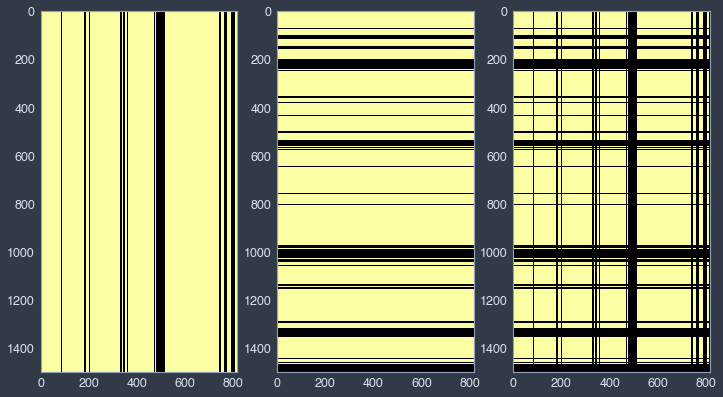

In [46]:
data, labels, mask = create_dataset(21, save=True)

(1500, 818, 2)


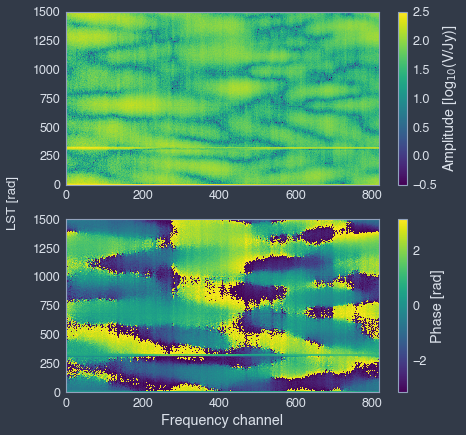

In [33]:
plot_one_vis(labels[0], 1500, 2.5, 3, (7,7), "")

# Visualize predictions

In [12]:
model = keras.models.load_model('model.h5', custom_objects={'masked_MSE': masked_MSE})

NameError: name 'masked_MSE' is not defined

(1500, 818, 2)
(1500, 818, 3)
(1500, 818, 2)


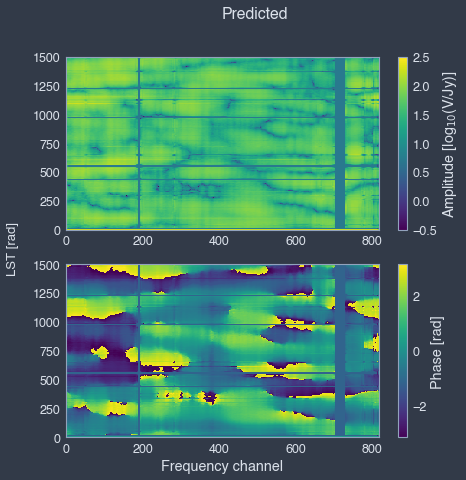

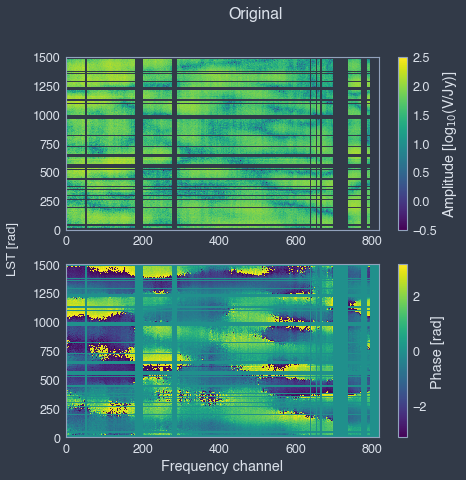

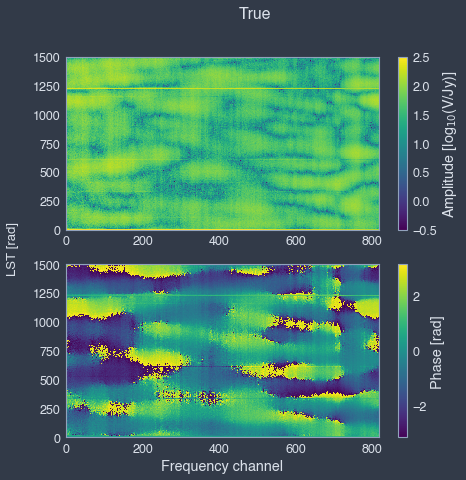

In [40]:
def visualize_predictions():
#     plot_one_vis(np.load("og.npy")[:,:,0], 1500, 2.5, 3, (7,7), "Original")
    plot_one_vis(np.load("generated/pred.npy"), 1500, 2.5, 3, (7,7), "Predicted")
    plot_one_vis(np.load("generated/og.npy"), 1500, 2.5, 3, (7,7), "Original")
    plot_one_vis(np.load("generated/true.npy"), 1500, 2.5, 3, (7,7), "True")
    
visualize_predictions()

In [15]:
arr = np.load("generated/pred.npy")
arr

array([[[ 1.22296013e-01, -1.78111484e-03],
        [ 1.36646360e-01, -1.99011271e-03],
        [ 1.70268402e-01, -2.47978303e-03],
        ...,
        [ 1.70269936e-01, -2.47980538e-03],
        [ 7.39144981e-02, -1.07648817e-03],
        [ 9.51517969e-02, -1.38578750e-03]],

       [[ 1.34592280e-01, -1.96019723e-03],
        [ 1.56541348e-01, -2.27986253e-03],
        [ 8.08035135e-02, -1.17681955e-03],
        ...,
        [ 8.08033794e-02, -1.17681758e-03],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 1.77875593e-01, -2.59057409e-03],
        [ 2.77218342e-01, -4.03739838e-03],
        [ 2.38111556e-01, -3.46784852e-03],
        ...,
        [ 2.38111541e-01, -3.46784806e-03],
        [ 3.31462659e-02, -4.82741045e-04],
        [ 3.48605178e-02, -5.07707358e-04]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        ...,
     

In [ ]:
f.close()